# Subgraph Localization

**Author**: Amit Boyarski & Dani Kogan

## Intro




In [61]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from subgraph_matching_via_nn.subgraph_localization_algs.unconstrained_nonlinear_optimization import \
    nn_subgraph_localization
from subgraph_matching_via_nn.graph_metric_networks.graph_matric_nn import \
    GraphMetricNetwork
from subgraph_matching_via_nn.composite_nn.compiste_nn import CompositeNeuralNetwork
from subgraph_matching_via_nn.graph_classifier_networks.node_classifier_networks import \
    NNNodeClassifierNetwork, IdentityNodeClassifierNetwork, GCNNodeClassifierNetwork
from subgraph_matching_via_nn.utils.utils import uniform_dist, NP_DTYPE, TORCH_DTYPE
from subgraph_matching_via_nn.graph_embedding_networks.graph_embedding_nn import \
    MomentEmbeddingNetwork
import torch
from subgraph_matching_via_nn.utils.utils import plot_degree_distribution, \
    plot_graph_with_colors
from subgraph_matching_via_nn.utils.utils import plot_indicator
from torch import tensor
import kmeans1d
from subgraph_matching_via_nn.graph_processors.graph_processors import GraphProcessor
from subgraph_matching_via_nn.utils.utils import get_node_indicator, get_edge_indicator
from subgraph_matching_via_nn.data.data_loaders import load_graph

plt.rcParams["figure.figsize"] = (6, 3)  # Set the desired figure size (width, height)

In [62]:

# Set the size of the graph and the subgraph
n = 10  # Number of nodes in the graph (for random graph)
m = 5  # Number of nodes in the subgraph (for random graph)
seed = 10  # for plotting

G, G_sub = load_graph(graph_size=n, subgraph_size=m,
                      type='example')  # type = 'random', 'example'

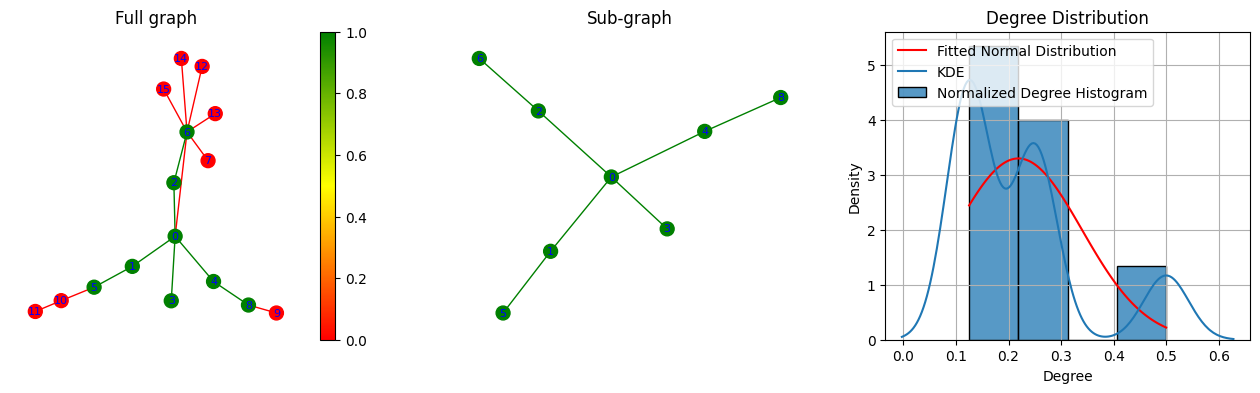

First 4 moments: ['0.2188', '0.0625', '0.0225', '0.0094', '0.0043', '0.0020']


In [63]:


w_indicator = get_node_indicator(G=G, G_sub=G_sub)
edge_indicator, subgraph_adj_matrix = get_edge_indicator(G=G, G_sub=G_sub)

# Call the function to plot the graph with colors
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
plot_graph_with_colors(G=G, G_sub=G_sub, edge_indicator=edge_indicator, ax=axes[0],
                       colorbar=False, title='Full graph', seed=seed, draw_labels=True)
plot_graph_with_colors(G=G_sub, G_sub=G_sub, ax=axes[1], colorbar=False,
                       title='Sub-graph', seed=seed, draw_labels=True)
# Plot degree distribution and compute first 4 moments
n_moments = 6
moments = plot_degree_distribution(G_sub, n_moments=n_moments, ax=axes[2])
plt.show()
print(f"First 4 moments: {[f'{value:.4f}' for value in moments]}")

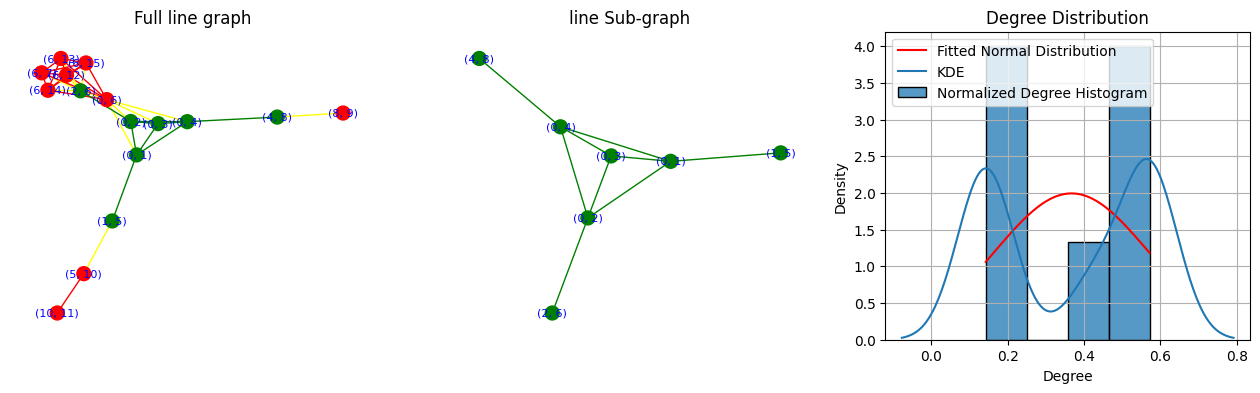

First 4 moments: ['0.3673', '0.1749', '0.0925', '0.0507']


In [64]:
# Transform to line
graph_processor = GraphProcessor(to_bipartite=False,
                                 to_line=True)
processed_G = graph_processor.pre_process(G)
processed_G_sub = graph_processor.pre_process(G_sub)

gt_node_indicator_line = np.array([edge_indicator[edge] for edge in processed_G.nodes()])
# test_edge_indicator = dict(zip(processed_G.nodes(), gt_node_indicator_line))
# print(f"{test_edge_indicator=}")
# print(f"{edge_indicator = }")


# Call the function to plot the graph with colors
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
plot_graph_with_colors(G=processed_G, G_sub=processed_G_sub,
                       node_indicator=gt_node_indicator_line,
                       ax=axes[0], colorbar=False, title='Full line graph', seed=seed,
                       draw_labels=True)
plot_graph_with_colors(G=processed_G_sub, G_sub=processed_G_sub, ax=axes[1],
                       colorbar=False,
                       title='line Sub-graph', seed=seed, draw_labels=True)
# Plot degree distribution and compute first 4 moments
n_moments = 4
moments = plot_degree_distribution(processed_G_sub, n_moments=n_moments, ax=axes[2])
plt.show()
print(f"First 4 moments: {[f'{value:.4f}' for value in moments]}")

In [101]:
from subgraph_matching_via_nn.graph_classifier_networks.node_classifier_networks import \
    sigmoid_layer, squared_normalized_layer, softmax_layer
from subgraph_matching_via_nn.subgraph_localization_algs.unconstrained_nonlinear_optimization import \
    binary_penalty, graph_entropy, spectral_reg, graph_total_variation

# --------- split -----------
# Assuming you have your graph G and subgraph G_sub defined
w_gt = (tensor(w_indicator)[:, None].float() / tensor(w_indicator).sum()).type(
    TORCH_DTYPE)
A_full = torch.from_numpy(nx.to_numpy_array(G)).type(TORCH_DTYPE)
A_sub = torch.from_numpy((nx.adjacency_matrix(G_sub)).toarray()).type(TORCH_DTYPE)
params = {}
params["maxiter"] = 1000
params["lr"] = 0.0002  # 0.0002 is optimal
params["n_moments"] = 6
params["m"] = len(G_sub.edges())
params["reg_param"] = 0.02  # reg param
params["k_update_plot"] = 250
params["moment_type"] = "standardized"  # 'central' ,'raw', 'standardized'
params["reg_term"] = binary_penalty
# Example usage
input_dim = len(G.edges())  # Input feature dimension
hidden_dim = 20  # Hidden dimension
output_dim = len(G.edges())
last_layer = softmax_layer
# node_classifier_network = NNNodeClassifierNetwork(input_dim=input_dim,
#                                                   hidden_dim=hidden_dim,
#                                                   output_dim=output_dim,
#                                                   learnable_sigmoid=False,
#                                                   default_sigmoid_param_value=1.0,
#                                                   last_layer=last_layer
#                                                   )
node_classifier_network = IdentityNodeClassifierNetwork(input_dim=input_dim,
                                                        learnable_sigmoid=False,
                                                        default_value_sigmoid_param=1.0,
                                                        last_layer=last_layer)
# node_classifier_network = GCNNodeClassifier(input_dim=1,
#                                       hidden_dim=hidden_dim,
#                                       num_classes=1,
#                                       learnable_sigmoid=True,
#                                       default_value_sigmoid_param=1)
node_classifier_network.train_node_classifier()
embedding_nn = MomentEmbeddingNetwork(n_moments=params["n_moments"],
                                      moments_type=params["moment_type"])
composite_nn = CompositeNeuralNetwork(node_classifier_network=node_classifier_network,
                                      embedding_network=embedding_nn)

loss_fun = torch.nn.MSELoss()
graph_metric_nn = GraphMetricNetwork(loss_fun=loss_fun)
w_all = []

# --------- split here-----------


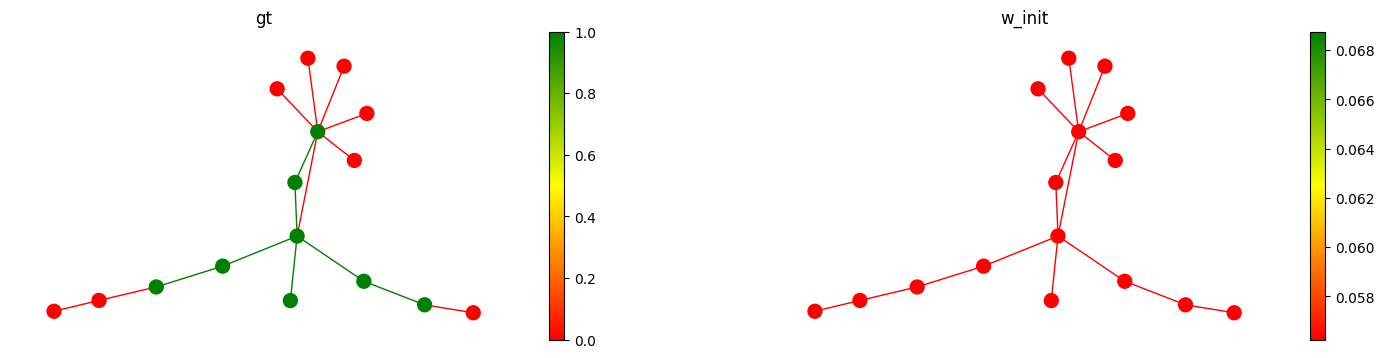

init loss: 20.573201539806693
init full loss: 20.573330685214856
init standardized moments: : ['0.1459', '2.6084', '2.3499', '9.8929']
sub standardized moments: ['-0.1467', '1.1471', '-0.2894', '1.3427']


In [102]:
# Initialize the parameters
#x0 = w_gt.clone() + 0.01*torch.rand(w_gt.shape, dtype=TORCH_DTYPE)
A_full_processed = torch.from_numpy((nx.adjacency_matrix(processed_G)).toarray()).type(TORCH_DTYPE)
A_sub_processed =  torch.from_numpy((nx.adjacency_matrix(processed_G_sub)).toarray()).type(TORCH_DTYPE)

edge_mask_gt = tensor(gt_node_indicator_line)[:, None].type(TORCH_DTYPE)
edge_mask_gt = edge_mask_gt / edge_mask_gt.sum()
x0 = (edge_mask_gt.clone() + 0.1 * torch.rand(edge_mask_gt.shape, dtype=TORCH_DTYPE))
x0 = x0 / torch.sum(x0)
composite_nn.node_classifier_network.init_params()
w_init = node_classifier_network.forward(A_full_processed).detach().numpy()
w_init_dict = dict(zip(processed_G.nodes(),w_init ))

# print(f"x0 = {x0.T}")
# print(f"gt = {edge_mask_gt.T}")
# print(f"nn params = {w_init.T}")

fig, axes = plt.subplots(1, 2, figsize=[18, 4])
plot_graph_with_colors(G=G, G_sub=G_sub, title='gt',edge_indicator=edge_indicator , ax=axes[0], seed=seed)
plot_graph_with_colors(G=G, G_sub=G_sub, title='w_init',edge_indicator=w_init_dict , ax=axes[1], seed=seed)
plt.show()

embedding_full, w = composite_nn(A_full_processed)
embedding_sub = composite_nn.embedding_network(
    A=A_sub_processed.detach().type(TORCH_DTYPE),
    w=uniform_dist(A_sub_processed.shape[0]).detach())
loss = graph_metric_nn(embedding_full=embedding_full,
                       embedding_subgraph=embedding_sub)
print(f"init loss: {loss}")  # + regularization
reg = params["reg_term"](A_full_processed, w, params)
full_loss = loss + params["reg_param"]  * reg
print(f"init full loss: {full_loss}")

embedding_with_init, _ = composite_nn(A=A_full_processed)
embedding_gt = composite_nn.embedding_network(
    A=A_full_processed.detach().type(TORCH_DTYPE),
    w=edge_mask_gt)
print(
    f"init {params['moment_type']} moments: : {[f'{value:.4f}' for value in embedding_with_init]}")
print(
    f"sub {params['moment_type']} moments: {[f'{value:.4f}' for value in embedding_sub]}")

In [ ]:

num_rand_exp = 5
plt.figure(figsize=(3, 2))
for k in range(num_rand_exp):
    # TODO: how do I initialize all network params?
    # params["x0"] = x0/torch.sum(x0)
    # params["x0"] = w_gt.T
    #composite_nn.init_params()
    nn_subgraph_localization(G=G,
                             G_sub=G_sub,
                             composite_nn=composite_nn,
                             graph_metric_nn=graph_metric_nn,
                             graph_processor=graph_processor,
                             params=params,
                             )
    opt_mask = node_classifier_network.forward(A_full).detach()
    w_star = opt_mask.numpy()
    w_all.append(w_star)
    print(k)


Iteration 0, Loss: 0.0230891081506856
Iteration 0, Loss: 0.0230891081506856


In [ ]:
#mask_generator_nn.init_params(default_weights=w_gt.clone().detach(), default_sigmoid_param=torch.tensor([20]))
A_full_processed = torch.from_numpy(
    nx.to_numpy_array(graph_processor.pre_process(G))).type(TORCH_DTYPE)
A_sub_processed = torch.from_numpy(
    nx.to_numpy_array(graph_processor.pre_process(G_sub))).type(TORCH_DTYPE)

opt_mask = node_classifier_network.forward(A_full_processed).detach()
w_star = opt_mask.numpy()
w_star_edge = dict(zip(processed_G.nodes(), w_star))
# TODO: write binarization algorithm. Put into processor.
#w_th, centroids = kmeans1d.cluster(w_star, k=2)
indices_of_top_m = np.argsort(w_star, axis=0)[-params["m"]:]  # top m
w_th = np.zeros_like(w_star, dtype=NP_DTYPE)
w_th[indices_of_top_m] = 1
#w_th = (w_star>np.quantile(w_star, (n-m)/n))
#w_th = np.array(w_th, dtype=np.float64)
w_th = w_th / w_th.sum()
w_th_edge = dict(zip(processed_G.nodes(), w_th))

w_bootstrap = np.array(w_all).mean()
w_bootstrap = w_bootstrap / w_bootstrap.sum()

est_moments = embedding_nn(w=tensor(w_star, requires_grad=False),
                           A=A_full_processed.detach()).type(TORCH_DTYPE)
est_moments_th = embedding_nn(w=tensor(w_th, requires_grad=False),
                              A=A_full_processed).type(TORCH_DTYPE)

fig, axes = plt.subplots(1, 3, figsize=[18, 4])
plot_graph_with_colors(G=G, G_sub=G_sub, edge_indicator=w_star_edge, title='w_star',
                       ax=axes[0], seed=seed)
plot_graph_with_colors(G=G, G_sub=G_sub, edge_indicator=w_th_edge, title='w_th',
                       ax=axes[1], seed=seed)
plot_graph_with_colors(G=G, G_sub=G_sub, title='gt sub', ax=axes[2], seed=seed)
plt.show()

# turn indicator into tensor and normalize to get distribution on nodes of line graph
gt_node_distribution_line = tensor(gt_node_indicator_line)[:, None].type(TORCH_DTYPE)
gt_node_distribution_line = gt_node_distribution_line / torch.sum(
    gt_node_distribution_line)
embedding, _ = composite_nn(A_full_processed)
embedding_sub = composite_nn.embedding_network(
    A=A_sub_processed.detach().type(TORCH_DTYPE),
    w=uniform_dist(A_sub_processed.shape[0]).detach())
embedding_gt = composite_nn.embedding_network(
    A=A_full_processed.detach().type(TORCH_DTYPE),
    w=gt_node_distribution_line)
print(
    f"sub {params['moment_type']} moments: {[f'{value:.4f}' for value in embedding_sub]}")
print(
    f"gt {params['moment_type']} moments: {[f'{value:.4f}' for value in embedding_gt]}")
print(
    f"est {params['moment_type']} moments: {[f'{value:.4f}' for value in est_moments]}")
print(
    f"est {params['moment_type']} moments_th: {[f'{value:.4f}' for value in est_moments_th]}")

loss = graph_metric_nn(embedding, embedding_gt)
print(f"loss = {loss}")
plot_indicator([gt_node_distribution_line, w_star, w_th], ['w_gt', 'w_star', 'w_th'])